# Section 3: Data Cleaning
- [Section 3.1: Initial Exploration and Cleaning](#explor)
- [Section 3.2: Type Conversion](#type)
- [Section 3.3: Missing Values](#missing)
- [Section 3.4: Outliers](#outs)

## Section 3.1: Initial Exploration and Cleaning <a class="anchor" id="explor"></a>

So, now we have tweets regarding the olympic sports of basketball, biking, diving, gymnastics, skateboarding, surfing, track, and volleyball. All og the tweets were collected into a single dataframe.

In [1]:
import pandas as pd
olympic_df = pd.DataFrame(columns=['id', 'created_at', 'conversation_id', 'text'])
sports = ['basketball', 'biking', 'diving','gymnastics','skateboard','surfing','track','volleyball']
for s in sports:
	# print(f'Deserializing {s}')
	df = pd.DataFrame(pd.read_pickle('../data/' + s + '-tweets.pkl'))
	df['sport'] = s
	olympic_df = olympic_df.append(df, ignore_index=True)

Now we have all of the tweets in single dataframe, making it easier for us to look at all of the tweets and clean them in bucnhes. During this process a new variable was created, sport. This varibale will track for us the sport that each tweet is talking about. When we make our sentiment analysis model later this will be very handy when anayzing by sport.

In [2]:
olympic_df.shape

(30554, 6)

Using the shape function we find that we have 30544 tweets. Time to get our hands dirty and clean the data.

As with all NLP data there is alot of cleaning that can be done. For this project we will be concentrating on removal of certain entities such as url links and hashtags, removal of stopwords, lemmatization, and general NLP text cleaning. After this NLP specific cleaning we should be ready to analyze the sentiment of tweets.

In [22]:
import re
def clean_tweet_text(text):
	"""Cleanses a tweet text of user mentions, links, hashtags, special characters, and emojis."""

	# Define any custom replacement pattern and join into an aggregated pattern
	replacements = [
		r'(@[\w]+)',
		r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
		r'(#\w+)',
		r'[\$&+,:;=?@#|\'<>.^*()%!-/]',
		r'\n',
		r'[0-9]+'
	]
	aggregate_pattern = r'|'.join(replacements)
	clean_text = re.sub(aggregate_pattern, '', text) # make regex substitutions in one pass
	
	# Return the unicode-stripped text in lowercase
	return clean_text.encode(encoding='ascii', errors='ignore').decode('ascii').lower()

# Make replacements
olympic_df['clean_text'] = olympic_df.text.apply(lambda row : clean_tweet_text(row))

In [23]:
olympic_df.sample(10)

,id,created_at,conversation_id,text,sport,withheld,clean_text
12335,1217814528,2021-08-07 01:17:25+00:00,1217814528,Not the worst start for Tom but the only thing...,diving,NaN,not the worst start for tom but the only thing...
29805,1758965761,2021-08-06 05:32:00+00:00,1758965761,#OLYMPICS @WSportsNews247 - curating #WomeninS...,volleyball,NaN,curating by sportcheck outgt make news you...
24229,1209376772,2021-08-07 12:08:11+00:00,1209376772,Glory glory Gold🥇....#NeerajChopra wins 🥇 for ...,track,NaN,glory glory gold wins for indias first medal ...
24121,-107716604,2021-08-07 12:10:16+00:00,-107716604,First medal in track and field at #Olympics th...,track,NaN,first medal in track and field at that too a ...
17261,-1755967486,2021-08-05 23:02:16+00:00,957853707,"@C_Patterson23 Thank You, Simone Biles - Headp...",gymnastics,NaN,thank you simone biles headphonesthoughts v...
21620,-1529589757,2021-08-09 07:45:52+00:00,-1529589757,Olympics: Feats in track &amp; field beyond Ch...,track,NaN,olympics feats in track amp field beyond chopr...
21368,-623546366,2021-08-06 04:24:32+00:00,-623546366,Made my first NFT 4 hours ago and already sold...,surfing,NaN,made my first nft hours ago and already sold ...
2033,1368756228,2021-08-07 13:58:24+00:00,1368756228,@BenSimmons25 I hope you watched that boomers ...,basketball,NaN,i hope you watched that boomers bronze medal ...
12105,-220913663,2021-08-07 04:08:39+00:00,-220913663,#Olympics #Diving #Usa #RhythmicGymnastics #...,diving,NaN,dame time
9921,1406611457,2021-07-25 10:51:28+00:00,0,RT @aitaikimochi: ALL RIGHT TOKYO #OLYMPICS YO...,biking,NaN,rt all right tokyo you set the bar high for ...


Stopwords are common words in the English language such as the, an, a, etc. These words are used much in English but convey little meaning. In most NLP applictions stop words have very little value and only slow down your model due to their high frequency. While these words shouldn't effect our model that much we will still remove them. The NLTK library has provides a wide assortment of tools to use for NLP. It even includes a list of stopwords we can use. By iterating over our text and comparing the text to the list of stopwords we can remove them for our tweets.

In [24]:
from nltk.corpus import stopwords
stops = stopwords.words('english')
stop_removal=lambda x: ' '.join([word for word in x.split() if word not in stops])
olympic_df['clean_no_stops'] = olympic_df.clean_text.apply(stop_removal)

In [ ]:
from nltk.stem import WordNetLemmatizer
wn_lemmatizer = WordNetLemmatizer()
olympic_df['lemma_text'] = olympic_df.clean_no_stops.apply(lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ])
olympic_df.sample(5)

## Section 3.2: Type Conversion <a class="anchor" id="type"></a>

We needed to change a few data types. Thankfully, the tweet text was already given to us as an object (string). To make our analysis easier we changed the tweet id and the conversation ids of type int from tyoe object. To facilitate the time aspect of our anaysis we needed to also covert the created_at variable to a datetime object.

In [3]:
olympic_df.id = olympic_df.id.astype('int32')
olympic_df.created_at = pd.to_datetime(olympic_df.created_at)
olympic_df.conversation_id = olympic_df.conversation_id.astype('int32')

This leaves us with these variable types the correct variable types.

In [5]:
olympic_df.dtypes

id                               int32
created_at         datetime64[ns, UTC]
conversation_id                  int32
text                            object
sport                           object
withheld                        object
dtype: object

## Section 3.3: Missing Values <a class="anchor" id="missing"></a>

Twitter keeps track of everything about a tweet. This is good news to us because the twitter API rarely gives you missing values. The below plot shows that there is no missing values.

<AxesSubplot:>

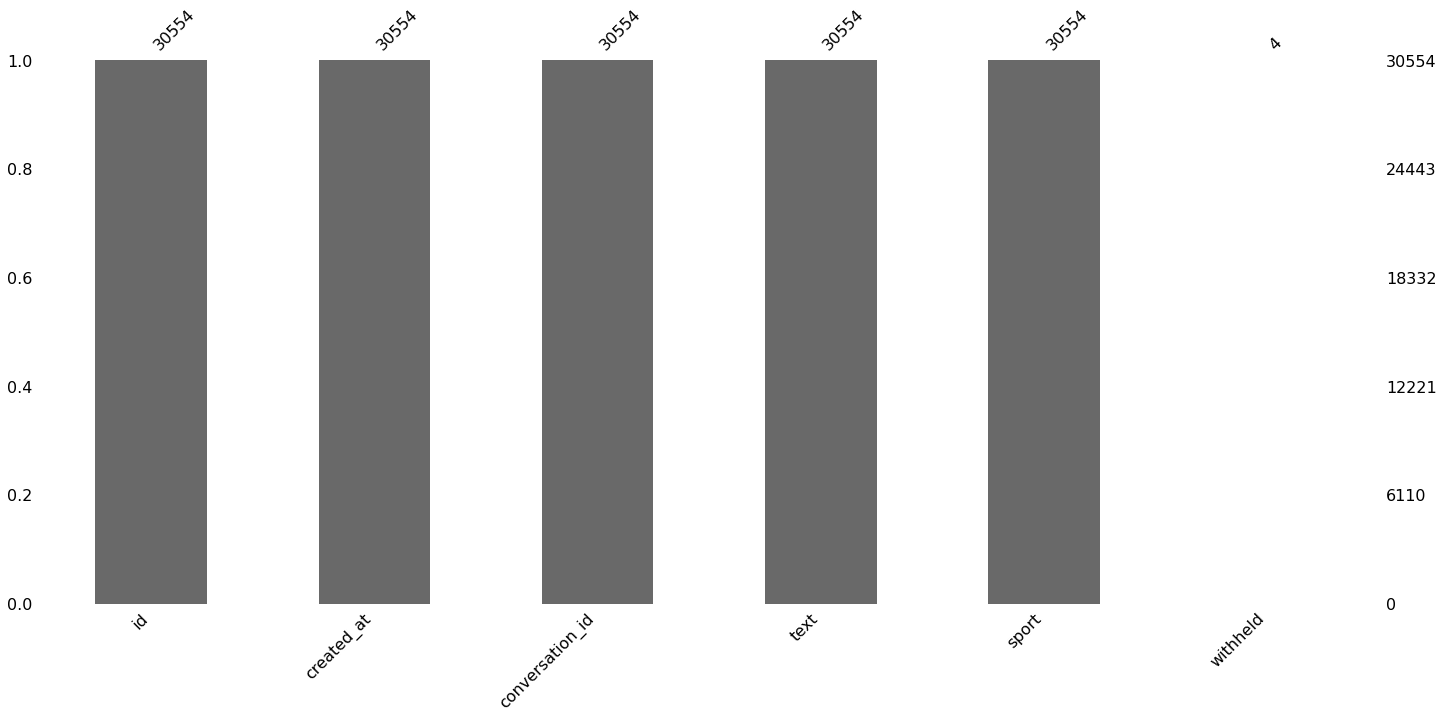

In [12]:
import missingno as msno
msno.bar(olympic_df)

Because we do not have any missing values we do not have to fill in any of these values.

## Section 3.4: Outliers <a class="anchor" id="outs"></a>

With text data it can be difficult to define what an outlier is. Obviously be can say obnoxiously positive and negative stuff without really nowing anything; this *definatly* doesn't happen on twitter (wink wink). However, the only real way to detict this is after the sentiment model is built. Also how do we know what are genuine tweets taht should be factored in our anaysis and bogus tweets that should not. We do assume tha most people that are tweeting about the Olympics are at least watching them. This is also our main target audience in this study; average peeople watching the Olympics. With it being impossible to detect bogus tweets from the API and our assumption that a vast majoroity of our tweets originate from our target audience, we decide to anaylze all of the tweets we could get. Potentially this could skew our sentiment scores. However, we feel confident that with the number of good tweets this potential skew effect should be drowned out.

<div class="container">
   <div style="float:left;width:20%"><a href="./Ingestion.ipynb"><< Section 2: Data Ingestion</a></div>
   <div style="float:right;width:20%"><a href="./Model.ipynb">Section 4: Model Creation >></a></div>
   <div style="float:right;width:40%"><a href="../main.md">Table of Contents</a></div>
</div>